<h1>Video Colorizer</h1>

<h3>Using a Generative Adversarial Network</h3>

In [1]:
import os
import random
import matplotlib.pyplot as plt
import imageio
import numpy as np
from tqdm import tqdm
import tensorflow as tf
import colorizerutils as utils
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import initializers

<h3>Limiting VRAM - Hardware Specific</h3>

The following cell limits the amount of VRAM tensorflow is allowed to use. This is necessary on my workstation because of my atypical hardware. This will likely need to be changed if this notebook is run on another machine.

In [2]:
# The amount of GPU memory to allocate to Tensorflow
vram = 14 # GB

gpus = tf.config.list_physical_devices('GPU')

tf.config.set_logical_device_configuration(
    gpus[0],
    [tf.config.LogicalDeviceConfiguration(memory_limit=vram*1024)])

tf.__version__

'2.8.0'

<h3>Training Dataset</h3>

The second dataset used to train a model is the television show <a href=https://en.wikipedia.org/wiki/Dusty%27s_Trail>Dusty's Trail</a>. This show was selected because it is one of the few color television shows in the public domain. Episodes three through six were split into frames and served as the training set while episode seven served as the test set. Eight frames were extracted per second of video resulting in approximately 11,000 frames per 22 minute episode.

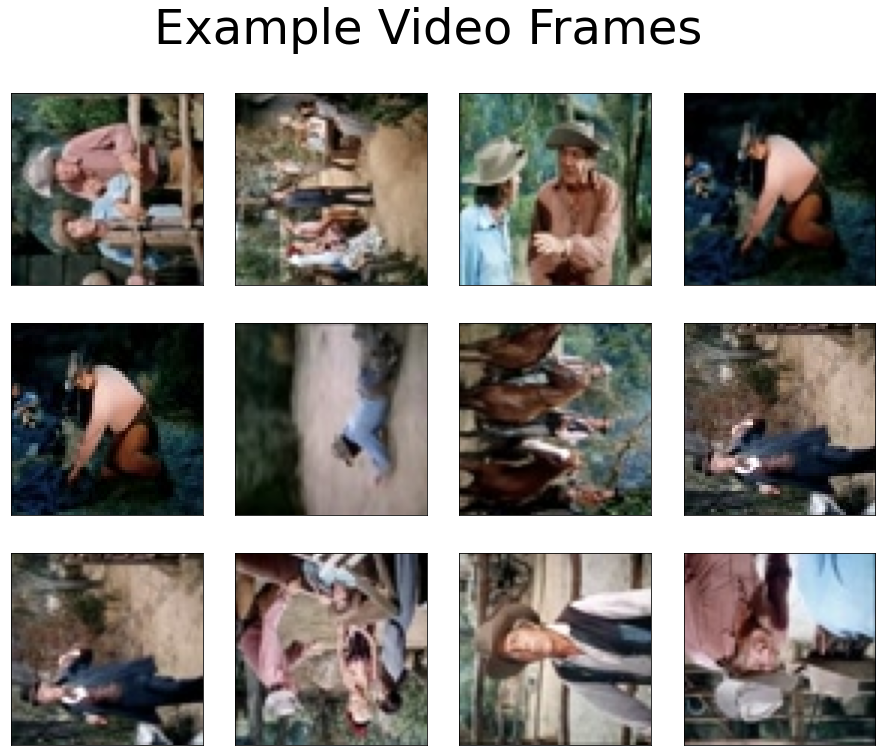

In [3]:
example_vid_paths = random.sample(os.listdir('../shows/episode3/'),12)
example_vid_paths = ['../shows/episode3/' + filename for filename in example_vid_paths]
example_frames = [utils.load_and_resize(path,transform=True) for path in example_vid_paths]

fig, ax = plt.subplots(3,4,figsize=(16,12))
for i, row in enumerate(ax):
    for j, col in enumerate(row):
        col.imshow(example_frames[j+3*i])
        col.set_xticks([])
        col.set_yticks([])
fig.set_facecolor('#FFFFFF')
fig.subplots_adjust(wspace=0.02, hspace=0.2)
fig.suptitle('Example Video Frames',fontsize=48);

The following cell creates the training dataset using the imageloader generator in colorizerutils.py. This needs to be a generator because the whole dataset does not fit in memory. It also sets up tensorboard logging for the generator loss, generator adversarial loss, generator mean squared error loss, and discriminator loss.

In [4]:
# Creates a dataset using images from ../images/train_images/
train_dataset = tf.data.Dataset.from_generator(
    lambda: utils.image_loader('../shows/trainepisodes/'),
    output_types=(tf.float32,tf.float32)
)

# Directory for tensorboard logs
log_directory = 'logs/'

# Set up tensorboard logging for the generator and discriminator loss
summary_writer = tf.summary.create_file_writer(log_directory + 'dusty/')
gen_loss_tracker = metrics.Mean('Generator_loss',dtype=tf.float32)
gen_adv_tracker = metrics.Mean('Generator_adversarial_loss',dtype=tf.float32)
gen_mse_tracker = metrics.Mean('Generator_mse_loss',dtype=tf.float32)
disc_loss_tracker = metrics.Mean('Discriminator_loss',dtype=tf.float32)

<h3>Generative Adversarial Network Structure</h3>
The colorizer uses a generative adversarial network (GAN) which contains a generator and a discriminator. The general structure of a GAN is shown here.<br><br>
<img src=resources/Gan_Arch.png width=200>

<h3>Neural Network Layers</h3>

The following cell creates downsampling and upsampling blocks of neural network layers. The upsampling blocks have two inputs: the previous upsampling block and a skip connection from the downsapling block of the same size. The downsampling blocks will be useful in both the generator and discriminator while the upsampling blocks will only be used in the generator.

In [5]:
# Downsampling block for use in generator and discriminator
def downsampling(filters,stride,prev_layer):

    init = initializers.RandomNormal()

    block = layers.Conv2D(filters,strides=stride,kernel_size=4,padding='same',kernel_initializer=init,
        use_bias=False)(prev_layer)
    block = layers.BatchNormalization()(block)
    block = layers.LeakyReLU(0.2)(block)

    return block

# Upsampling block for use in generator only
# Skip layer should be the same shape as the output to the transpose convolutional layer
# Or twice the size of the prev_layer input
def upsampling(filters,stride,prev_layer,skip_layer):

    init = initializers.RandomNormal()

    block = layers.Conv2DTranspose(
        filters,strides=stride,kernel_size=4,padding='same',kernel_initializer=init,
        use_bias=False)(prev_layer)
    block = layers.BatchNormalization()(block)
    block = layers.Concatenate()([block,skip_layer])
    block = layers.LeakyReLU(0.2)(block)
    block = layers.Dropout(0.3)(block)

    return block

<h3>Generator Architecture</h3>
<p>
The following cell creates the generator. The architecture of the generator is shown in the (not to scale) diagram below. It is composed of a series of downsampling blocks followed by a series of upsampling blocks. The input images are 64x64 pixels. The stride of 2 cuts the image resolution in half after each downsampling block. The stride of 2 in the upsampling blocks return the image to its original 64x64 pixel size.</p>

<img src=resources/generator_arch.png>

In [6]:
def make_generator():

    init = initializers.RandomNormal()

    # Model input is a (64x64) grayscale image
    model_input = layers.Input(shape=(64,64,1))

    # Downsampling stack
    down0 = downsampling(filters=32,stride=1,prev_layer=model_input) # (64x64) -> (64x64)
    down1 = downsampling(64,2,down0) # (64x64) -> (32x32)
    down2 = downsampling(128,2,down1) # (32x32) -> (16x16)
    down3 = downsampling(256,2,down2) # (16x16) -> (8x8)
    down4 = downsampling(256,2,down3) # (8x8) -> (4x4)
    down5 = downsampling(256,2,down4) # (4x4) -> (2x2)
    down6 = downsampling(256,2,down5) # (2x2) -> (1x1)


    # Upsampling stack
    up5 = upsampling(filters=256,stride=2,prev_layer=down6,skip_layer=down5) # (1x1) -> (2x2)
    up4 = upsampling(256,2,up5,down4) # (2x2) -> (4x4)
    up3 = upsampling(256,2,up4,down3) # (4x4) -> (8x8)
    up2 = upsampling(128,2,up3,down2) # (8x8) -> (16x16)
    up1 = upsampling(64,2,up2,down1) # (16x16) -> (32x32)
    up0 = upsampling(32,2,up1,down0) # (32x32) -> (64x64)
    
    # Model output is (64x64) with 2 color channels with values between -1 and 1
    model_output = layers.Conv2DTranspose(
        2,strides=1,kernel_size=4,padding='same',activation='tanh',kernel_initializer=init,use_bias=False)(up0)

    model = keras.models.Model(model_input,model_output)
    return model

<h3>Generator Loss</h3>

<p>The generator loss is the weighted sum of mean squared error loss and adversarial loss. Mean squared error loss is simply the squared difference between the generated images and the original images. Adversarial loss takes the discriminator's classification of the generator's output into account. The more generated images the discriminator thinks are original, the lower the loss.</p>

<img src=resources/Gen_Training_Loop.png>

In [7]:
def generator_loss(disc_output_generated,generator_output,color_channels):

    # Part of the loss is based on the discriminator output on fake images
    cross_entropy = losses.BinaryCrossentropy(from_logits=True,label_smoothing=0.1)

    # Part of the loss (scaled) is based on the difference between the
    # generated images and the original colored images
    mse = losses.MeanSquaredError()
    mse_scaler = 25

    # Generator wants the discriminator to classify the generated images as 1 (real)
    # Adersarial loss is the defference between all 1s and the actual discriminator output
    adversarial_loss = cross_entropy(tf.ones_like(disc_output_generated),disc_output_generated)
    mse_loss = mse(generator_output,color_channels) 

    # Return all three losses for tensorboard
    return adversarial_loss + (mse_scaler * mse_loss), adversarial_loss, mse_loss

The following cell initializes the generator and generator optimizer, and prints the architecture of the generator.

In [8]:
# Create the generator and generator optimizer
generator = make_generator()

# Beta1 to decrease importance of previous batches
generator_optimizer = optimizers.Adam(2e-4,beta_1=0.5)
generator.compile()
generator.summary()
#keras.utils.plot_model(generator,show_shapes=True,to_file='generator.png',dpi=48)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   512         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  128         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 64, 64, 32)   0           ['batch_normalization[0][0]']

<h3>Discriminator Architecture</h3>

<p>The discriminator uses a more typical convolutional neural network architecture made from downsampling blocks. It recieves 64x64 pixel images as an input and outputs eight predictions of whether a section of the input image was generated or originally colored.</p>

<img src=resources/discriminator_arch.png>

In [9]:
def make_discriminator():

    init = initializers.RandomNormal()

    gray_input = layers.Input(shape=(64,64,1))
    color_input = layers.Input(shape=(64,64,2))

    # Gray and colored inputs are combined
    concat_input = layers.concatenate([gray_input,color_input])

    # Downsampling stack
    down0 = downsampling(filters=64,stride=2,prev_layer=concat_input) # (64x64) -> (32x32)
    down1 = downsampling(128,2,down0)        # (32x32) -> (16x16)
    down2 = downsampling(256,2,down1)        # (16x16) -> (8x8)

    # Model output is (8x8) with unbounded values (no activation)
    model_output = layers.Conv2D(1,2,strides=1,padding='same',kernel_initializer=init,use_bias=False)(down2)

    model = keras.Model(inputs=[gray_input,color_input],outputs=model_output)
    return model

<h3>Discriminator Loss</h3>

<p>The discriminator loss is calculated from the number of predictions the discriminator got correct. It will be higher if the discriminator can not tell the generated images apart from the originally colored images. The following cell defines this loss function.</p>

<img src=resources/Disc_Training_Loop.png width=300>

In [10]:
def discriminator_loss(disc_output_generated,disc_output_real):

    cross_entropy = losses.BinaryCrossentropy(from_logits=True,label_smoothing=0.1)

    # Discriminator wants to classify real images as 1 and generated
    # images as 0. Loss is the difference between the desired outputs
    # and the actual outputs
    real_loss = cross_entropy(tf.ones_like(disc_output_real),disc_output_real)
    generated_loss = cross_entropy(tf.zeros_like(disc_output_generated),disc_output_generated)

    total_loss = real_loss + generated_loss
    return total_loss

The following cell initializes the discriminator and discriminator optimizer, and prints the architecture of the discriminator.

In [11]:
# Make the discriminator and discriminator optimizer
discriminator = make_discriminator()
discriminator_optimizer = optimizers.Adam(2e-4)
discriminator.compile()
discriminator.summary()
#keras.utils.plot_model(discriminator,show_shapes=True,to_file='discriminator.png',dpi=48)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 64, 64, 2)]  0           []                               
                                                                                                  
 concatenate_6 (Concatenate)    (None, 64, 64, 3)    0           ['input_2[0][0]',                
                                                                  'input_3[0][0]']                
                                                                                                  
 conv2d_7 (Conv2D)              (None, 32, 32, 64)   3072        ['concatenate_6[0][0]']    

<h3>GAN Training Loop</h3>
<p>The following cell defines a train step for the GAN. The generator recieves gray images as inputs and outputs color images. The discriminator recieves these generated color images and original colored images and makes predictions on which are generated and which are original. Then, each model is updated based on the discriminator's predictions and the mean squared error difference between the generated images and the real images. Finally tensorboard is updated. Further details on the training loops for the generator and discriminator can be found in the generator and discriminator loss sections above.

In [12]:
@tf.function
def train_step(gray_channel,color_channels):

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

        # Generate a batch of fake images
        generator_output = generator(gray_channel,training=True)

        # Get discriminator output on real and generated images
        disc_output_real = discriminator([gray_channel,color_channels],training=True)
        disc_output_generated = discriminator([gray_channel,generator_output],training=True)

        # Calculate loss for generator and discriminator based on discriminator outputs
        gen_loss, adversarial_loss, mse_loss = generator_loss(disc_output_generated,generator_output,color_channels)
        disc_loss = discriminator_loss(disc_output_generated,disc_output_real)

    # Calculate generator gradients and train generator
    generator_gradients = gen_tape.gradient(gen_loss,generator.trainable_variables)
    generator_optimizer.apply_gradients(zip(generator_gradients,generator.trainable_variables))

    # Calculate disciminator gradients and train discriminator
    discriminator_gradients = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients,discriminator.trainable_variables))

    # Update tensorboard losses
    gen_loss_tracker(gen_loss)
    gen_adv_tracker(adversarial_loss)
    gen_mse_tracker(mse_loss)
    disc_loss_tracker(disc_loss)

<h3>Training the GAN</h3>

The following cell creates a loop that trains the generator and discriminator and updates tensorboard for the specified number of epochs.

In [13]:
def train_model(epochs,dataset):
    
    step_counter = 0

    # Progress bar/tracking
    for _ in tqdm(range(epochs)):

        for gray_channel,color_channels in dataset:
            train_step(gray_channel,color_channels)

            # Tensorboard logging for training
            with summary_writer.as_default():
                tf.summary.scalar('Generator_loss',gen_loss_tracker.result(),step=step_counter)
                tf.summary.scalar('Generator_adversarial_loss',gen_adv_tracker.result(),step=step_counter)
                tf.summary.scalar('Generator_mse_loss',gen_mse_tracker.result(),step=step_counter)
                tf.summary.scalar('Discriminator_loss',disc_loss_tracker.result(),step=step_counter)
            
            gen_loss_tracker.reset_states()
            gen_adv_tracker.reset_states()
            gen_mse_tracker.reset_states()
            disc_loss_tracker.reset_states()
            step_counter += 1

The following cell runs the loop created in the previous cell to train the models, the saves the trained models.

In [14]:
#train_model(epochs=200,dataset=train_dataset)
#generator.save('models/dusty/generator.h5')
#discriminator.save('models/dusty/discriminator.h5')
dusty_gen = keras.models.load_model('models/1-9-23/dusty/generator.h5')
dusty_disc = keras.models.load_model('models/1-9-23/dusty/discriminator.h5')

<h3>Training Results</h3>

<p>
The four charts below show the discriminator loss, generator loss(adversarial), generator loss (mean squared error), and total generator loss.
</p>

<ul>
<li>The discriminator loss starts high and decreases over time as the discriminator learns to distinguish between the generator's predicted colors and the original color images.</li>
<li>The generator adversarial loss is the inverse of the discriminator loss. It increases over time because the discriminator improves more quickly than the generator.</li>
<li>The generator MSE loss decreases over time as the generator predicted images more closely resemble the original color images. The overall MSE is likely lower than the image colorization model because it is easier to fit to the many near duplicate frames.</li>
<li>The generator total loss is the weighted sum of the adversarial and MSE loss components. The MSE component is weighted lower than in the image colorization model. The MSE component is larger initially, but the adversarial component eventually begins to dominate.</li>
</ul>

<img src=resources/Dusty_Loss_TBoard.jpg></img>

<h3>Reconstructing Videos</h3>

The following function uses the generator to colorize a series of frames and reconstruct them into a video file. These video files needed to be gifs because actual video files do not render within a notebook on github.

In [15]:
save_folder = 'resources/video/'

def make_gifs(batch_size,batch_number,source='train'):


    # Select which data set to use
    if source == 'test':
        image_folder = '../shows/episode7/' 
    else:
        image_folder = '../shows/episode3/'

    # Lists for the frames which will be added to each gif
    grayscale_frames = []
    colorized_frames = []
    original_frames = []

    # Batch of images to be colorized
    # Batch size controls the length of the videos
    image_batch = utils.image_loader(directory=image_folder,
        batch_size=batch_size,training=False,sort_files=True).__getitem__(batch_number)

    # Use the generator to colorize the videos
    image_output = dusty_gen(image_batch[0],training=False)

    for frame_number,gray_frame in enumerate(image_batch[0]):

        # Use all 0s for color channels in the grayscale image
        grayscale_dummy_color = np.dstack([np.zeros_like(gray_frame),
            np.zeros_like(gray_frame)])

        # Add the frames to the corresponding list
        grayscale_frames.append(utils.lab_to_rgb_combine_channels(
            l_channel=gray_frame,
            ab_channels=grayscale_dummy_color
        ))

        colorized_frames.append(utils.lab_to_rgb_combine_channels(
            l_channel=gray_frame,
            ab_channels=image_output[frame_number]
        ))

        # image_batch[1] contains both original color channels
        original_frames.append(utils.lab_to_rgb_combine_channels(
            l_channel=gray_frame,
            ab_channels = image_batch[1][frame_number]
        ))

    # Save all three sets of frames as gifs
    with imageio.get_writer(save_folder + f'{source}_{batch_number}_grayscale.gif',mode='I',fps=8) as writer:
        for frame in grayscale_frames:
            writer.append_data(frame)

    with imageio.get_writer(save_folder + f'{source}_{batch_number}_colorized.gif',mode='I',fps=8) as writer:
        for frame in colorized_frames:
            writer.append_data(frame)

    with imageio.get_writer(save_folder + f'{source}_{batch_number}_original.gif',mode='I',fps=8) as writer:
        for frame in original_frames:
            writer.append_data(frame)

The following cell uses the function from the previous cell to colorize the frames and save them as gifs. The batch numbers control where the video starts and how long it is. The example scenes were selected to avoid showing unfitting content.

In [16]:
#Train set results
#make_gifs(batch_size=64,batch_number=20,source='train')
#make_gifs(batch_size=64,batch_number=40,source='train')

#Test set results selected to avoid unfitting content
#make_gifs(batch_size=64,batch_number=3,source='test')
#make_gifs(batch_size=64,batch_number=14,source='test')
#make_gifs(batch_size=64,batch_number=70,source='test')
#make_gifs(batch_size=64,batch_number=120,source='test')

<h3>Training Results</h3>

The leftmost column of videos shows the grayscale training frames. The center column of videos shows the generator colorized frames. The rightmost column shows the original color frames.

<table>
    <tr>
        <th>Grayscale Video</th>
        <th>Colorized Video</th>
        <th>Original Video</th>
    <tr>
        <td><img src=resources/video/train_20_grayscale.gif width=256></img></td>
        <td><img src=resources/video/train_20_colorized.gif width=256></img></td>
        <td><img src=resources/video/train_20_original.gif width=256></img></td>
    </tr>
    <tr>
        <th>Grayscale Video</th>
        <th>Colorized Video</th>
        <th>Original Video</th>
    <tr>
    <tr>
        <td><img src=resources/video/train_40_grayscale.gif width=256></img></td>
        <td><img src=resources/video/train_40_colorized.gif width=256></img></td>
        <td><img src=resources/video/train_40_original.gif width=256></img></td>
</table>